**В ДАННОМ БЛОКНОТЕ *ИССЛЕДУЕТСЯ* МЕТОД ОБНАРУЖЕНИЯ АНОМАЛИЙ СЕТЕВОГО ТРАФИКА НА ОСНОВЕ СТАТИСТИЧЕСКИХ ХАРАКТЕРИСТИК С ИСПОЛЬЗОВАНИЕМ МЕТОДОВ МАШИННОГО ОБУЧЕНИЯ

Основная суть идеи заключается в поиске корреляционных связей между временными рядами характеристик нормального и аномального сетевого трафика.
Работа производится на **размеченных данных**

Краткий алгоритм работы по шагам:
1. Загружаем данные из pcap в csv с выделением **значимых** характеристик сетевого трафика (конвертер лежит совместно с блокнотом)
2. Загружаем csv в блокнот
3. Агрегируем в первый раз, смотрим графики
4. Скользящим временным окном проходим по агрегированным данным, на каждом окне считаем статистические характеристики
5. Записываем все в csv
6. Смотрим как методы машинного обучения справляются с разделением заранее классифицированных данных, проводим анализ

In [1]:
### ЗАГРУЗКА НЕОБХОДИМЫХ БИБЛИОТЕК

import plotly as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import rcParams
import csv
rcParams['figure.figsize'] = 8, 5

In [2]:
# ИНИЦИАЛИЗАЦИЯ КЛАССА, В КОТОРЫЙ СОХРАНЯЕТСЯ CSV ФАЙЛ 

class Packet:
    def __init__(self,time,time_delta,time_delta_disp,time_relative, \
                time_epoch, length,ip_src, ip_dst,df, mf, rb, src_port, dst_port, \
                ack, syn , fin, clas):
        self.time = time
        self.time_delta = time_delta
        self.time_delta_disp = time_delta_disp
        self.time_relative = time_relative
        self.time_epoch = time_epoch
        self.length = length
        self.ip_src = ip_src
        self.ip_dst = ip_dst
        self.df = df
        self.mf = mf
        self.rb = rb
        self.src_port = src_port
        self.dst_port = dst_port
        self.ack = ack
        self.syn = syn
        self.fin = fin
        self.clas = clas
        
    def __repr__(self):
        return "В этом классе содержатся поля пакета"

        
    def __str__(self):
        return "В этом классе содержатся поля пакета"
    

### ИНИЦИАЛИЗАЦИЯ КЛАССА, ЭКЗЕМПЛЯРЫ КОТОРОГО БУДУТ ОТВЕЧАТЬ ЗА ХАРАКТЕРИСТИКИ 
### ПАКЕТОВ НА ИНТЕРВАЛАХ


class Interval:
    def __init__(self, length, mean_length, min_length, max_length,\
                intens, syn, ack, fin, unique_ip, intens_bit, ip_src, ip_dst, \
                src_port, dst_port, classification, unique_port):
        self.length = length
        self.mean_length = mean_length
        self.min_length = min_length
        self.max_length = max_length
        self.intens = intens
        self.syn = syn
        self.ack = ack
        self.fin = fin
        self.unique_ip = unique_ip
        self.intens_bit = intens_bit
        self.ip_src = ip_src
        self.ip_dst = ip_dst
        self.src_port = src_port
        self.dst_port = dst_port
        self.classification = classification
        self.unique_port = unique_port
        
        def __repr__(self):
            return "Экзмепляры этого класса отвечают за поля пакета на интервалах наблюдения"

        
        def __str__(self):
            return "Экзмепляры этого класса отвечают за поля пакета на интервалах наблюдения"    

In [7]:
### ЧТЕНИЕ CSV ФАЙЛА В КЛАСС Packet

array_object_of_Packet = []
len_of_csv = len(open('2pcaps.csv').readlines())
filename = '2pcaps.csv'

with open(filename, encoding='utf-8') as r_file:
    file_reader = csv.reader(r_file, delimiter=',')
    count = 0
    for row in file_reader:
        if count != 0:
            a = Packet(row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], \
                      row[8], row[9], row[10], row[11], row[12], row[13], row[14], row[15], \
                      row[16])
            array_object_of_Packet.append(a)
    #         print(a.length)
            count += 1
            del a
            if count == int(0.1*len_of_csv):
                print('10%')
            if count == int(0.2*len_of_csv):
                print('20%')
            if count == int(0.3*len_of_csv):
                print('30%')
            if count == int(0.4*len_of_csv):
                print('40%')
            if count == int(0.5*len_of_csv):
                print('50%')
            if count == int(0.6*len_of_csv):
                print('60%')
            if count == int(0.7*len_of_csv):
                print('70%')
            if count == int(0.8*len_of_csv):
                print('80%')
            if count == int(0.9*len_of_csv):
                print('90%')
            if count == len_of_csv:
                print('100%')
        else: 
            count += 1
    
print(f'{filename} содержит {count} записей')
print(f'Все данные загружены в массив объектов класса array_object_of_packet')


10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
2pcaps.csv содержит 410773 записей
Все данные загружены в массив объектов класса array_object_of_packet


In [8]:
### ФУНКЦИЯ ДЛЯ РАСЧЕТА ХАРАКТЕРИСТИК НА ИНТЕРВАЛЕ 
### ВХОД(ЛЕВ.ГР, ПР.ГР, МАССИВ, ШАГ)

def func(left_k, right_k, array, counter):
    ln = []
    bit = []
    syn = []
    ack = []
    fin = []
    ip_src = []
    ip_dst = []
    src_port = []
    dst_port = []
    unique_ip = []
    unique_port = []
    l = 0
    classifica = []
    for i in range(counter , len(array)):
        num = array[i].time_relative
        if left_k <= float(num) <= right_k:
            ln.append(int(array[i].length))
            bit.append(int(array[i].length) * 8)
            if int(array[i].syn) == 1:
                syn.append(1)
            else:
                syn.append(0)
            if int(array[i].fin) == 1:
                fin.append(1)
            else:
                fin.append(0)
            if int(array[i].ack) == 1:
                ack.append(1)
            else:
                ack.append(0)
#             if int(array[i].clas) == 1:
#                 l += 1
            classifica.append(int(array[i].clas))
            ip_src.append(array[i].ip_src)
            ip_dst.append(array[i].ip_dst)
            src_port.append(array[i].src_port)
            dst_port.append(array[i].dst_port)
            unique_ip.append('src: ' + array[i].src_port + \
                          ' dst: ' + array[i].ip_dst)
            unique_port.append('src: ' + array[i].dst_port + \
                          ' dst: ' + array[i].ip_dst)
        if right_k < float(array[i].time_relative):
            break
    if len(classifica) == sum(classifica):
        itog = 1
    else: 
        itog = 0
    classifica.clear()
    return ln, i, syn, ack, fin, ip_src, ip_dst, src_port, dst_port, len(set(unique_ip)), sum(bit), itog, len(set(unique_port))


# print('ln',func(0, 5, array_object_of_Packet, 0)[0])
# print('i',func(0, 5, array_object_of_Packet, 0)[1])
# print('syn',func(0, 5, array_object_of_Packet, 0)[2])
# print('ack',func(0, 5, array_object_of_Packet, 0)[3])
# print('fin',func(0, 5, array_object_of_Packet, 0)[4])
# print('ip_src',func(0, 5, array_object_of_Packet, 0)[5])
# print('ip_dst',func(0, 5, array_object_of_Packet, 0)[6])
# print('src_port',func(0, 5, array_object_of_Packet, 0)[7])
# print('dst_port',func(0, 5, array_object_of_Packet, 0)[8])
# print('unique',func(0, 5, array_object_of_Packet, 0)[9])
# print('sum(bit)',func(0, 5, array_object_of_Packet, 0)[10])
# print('itog',func(0, 20000, array_object_of_Packet, 0)[11])

# print(len(array_object_on_Interval))                                          
            

In [28]:
len(array_object_on_Interval)
# cnt = 0
# for x in array_object_on_Interval:
# #     if cnt >= 30678:
#     print(x.classification)
# #     cnt += 1

3839

In [9]:
### ФУНКЦИЯ ДЛЯ ДВИЖЕНИЯ ОКНА ПО МАССИВУ ARRAY_OBJECT_OF_PACKET

array_object_on_Interval = []
NUMBER = []
num = 0
k = float(input('Введите интервал -окно- наблюдения '))
# step = float(input('Введите шаг для движения окна '))
step = k
k1 = 0
k2 = k
cnt = 0
c = float(array_object_of_Packet[-1].time_relative)
# print(c)



print('Loading:')
while k1 <= c:
    if 0 <= k1 <= int(0.1*c):
        print(1 * '■' + 9 * '○')
    elif int(0.1*c) < k1 <= int(0.2*c):
        print(2 * '■' + 8 * '○')
    elif int(0.2*c) < k1 <= int(0.3*c):
        print(3 * '■' + 7 * '○')
    elif int(0.3*c) < k1 <= int(0.4*c):
        print(4 * '■' + 6 * '○')
    elif int(0.4*c) < k1 <= int(0.5*c):
        print(5 * '■' + 5 * '○')
    elif int(0.5*c) < k1 <= int(0.6*c):
        print(6 * '■' + 4 * '○')
    elif int(0.6*c) < k1 <= int(0.7*c):
        print(7 * '■' + 3 * '○')
    elif int(0.7*c) < k1 <= int(0.8*c):
        print(8 * '■' + 2 * '○')
    elif int(0.8*c) < k1 <= int(0.9*c):
        print(9 * '■' + 1 * '○')
    else:
        print(9 * '■' + 1 * '○')
        
    if len(func(k1, k2, array_object_of_Packet, cnt)[0]) != 0:
        b = Interval(func(k1, k2, array_object_of_Packet, cnt)[0],\
                     np.mean(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                     min(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                     max(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                     len(func(k1, k2, array_object_of_Packet, cnt)[0]),\
                     sum(func(k1, k2, array_object_of_Packet, cnt)[2]),\
                     sum(func(k1, k2, array_object_of_Packet, cnt)[3]),\
                     sum(func(k1, k2, array_object_of_Packet, cnt)[4]),\
                     func(k1, k2, array_object_of_Packet, cnt)[9],\
                     func(k1, k2, array_object_of_Packet, cnt)[10],\
                     func(k1, k2, array_object_of_Packet, cnt)[5],\
                     func(k1, k2, array_object_of_Packet, cnt)[6],\
                     func(k1, k2, array_object_of_Packet, cnt)[7],\
                     func(k1, k2, array_object_of_Packet, cnt)[8],\
                     func(k1, k2, array_object_of_Packet, cnt)[11],\
                     func(k1, k2, array_object_of_Packet, cnt)[12])
            
        array_object_on_Interval.append(b)
        NUMBER.append(num)
        del b
    else:
#         if func(k1, k2, array_object_of_Packet, cnt)[11] != 1:
#             b = Interval(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
#         else:
#         b = Interval(0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0)
#         array_object_on_Interval.append(b)
        NUMBER.append(num)
    cnt = func(k1, k2, array_object_of_Packet, cnt)[1]
    k1, k2 = k1 + step, k2 + step
    num += 1
# print(len(array_object_on_Interval))
# print(num)
# print(array_object_on_Interval[1].unique)
print(f'Data -array_object_of_Packet- downloaded with')
print(f'Window agregation = {k} and step = {step}')
print(len(array_object_of_Packet))

Введите интервал -окно- наблюдения 0.5
Loading:
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○

■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○

■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○

■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○

■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○

■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○

■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○

■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○

In [10]:
# ### ЗАПИШЕМ ВСЕ ДАННЫЕ В ДАТАФРЕЙМ  -->
# import seaborn as sns

# dff = pd.DataFrame([x.mean_length for x in array_object_on_Interval], columns=['mean_length'])
# dff['max_length'] = [x.max_length for x in array_object_on_Interval]
# dff['min_length'] = [x.unique_port for x in array_object_on_Interval]
# dff['intens_packet'] = [x.intens for x in array_object_on_Interval]
# dff['intens_bit'] = [x.intens_bit for x in array_object_on_Interval]
# dff['unique_ip'] = [x.unique_ip for x in array_object_on_Interval]
# dff['unique_port'] = [x.unique_port for x in array_object_on_Interval]
# dff['syn'] = [x.syn for x in array_object_on_Interval]
# dff['fin'] = [x.fin for x in array_object_on_Interval]
# dff['ack'] = [x.ack for x in array_object_on_Interval]
# dff['classif'] = [x.classification for x in array_object_on_Interval]
# dff.to_csv('./csv/vrem_int.csv', sep=',', encoding='utf-8', index=True)

# plt.scatter( range(len([x.mean_length for x in array_object_on_Interval])),\
#             [x.mean_length for x in array_object_on_Interval],\
#             c=dff['classif'].map({0: 'blue', 1: 'orange'}))
# print('File vrem_int.csv')



df = pd.DataFrame(columns=['mean_ln','min_ln','max_ln','intens_p','intens_bit',\
                  'unique_ip','unique_port','syn','fin','ack','classif'])
len_ar = len(array_object_on_Interval)
count = 0
Number0 = []
Number1 = []
array_object_on_Interval0 = []
array_object_on_Interval1 = []
for x in array_object_on_Interval:
    if x.classification == 1:
        array_object_on_Interval1.append(x)
        Number1.append(count)
    else:
        array_object_on_Interval0.append(x)
        Number0.append(count)
    count += 1
    df.loc[len(df)] = [x.mean_length, x.min_length, x.max_length, x.intens,\
                      x.intens_bit, x.unique_ip, x.unique_port, x.syn, x.fin,\
                      x.ack, x.classification]
    if count == int(0.1*len_ar):
        print('10%')
    if count == int(0.2*len_ar):
        print('20%')
    if count == int(0.3*len_ar):
        print('30%')
    if count == int(0.4*len_ar):
        print('40%')
    if count == int(0.5*len_ar):
        print('50%')
    if count == int(0.6*len_ar):
        print('60%')
    if count == int(0.7*len_ar):
        print('70%')
    if count == int(0.8*len_ar):
        print('80%')
    if count == int(0.9*len_ar):
        print('90%')
    if count == len_ar:
        print('100%')          
print(len(array_object_on_Interval))
print(len(array_object_on_Interval0), len(Number0))
print(len(array_object_on_Interval1), len(Number1))
# d = pd.DataFrame([[p.mean_length, p.min_length, p.max_length, p.intens] for p in array_object_on_Interval])
# print(df)
# df.to_csv('first_wind_agr=2_step=2.csv', sep=',', encoding='utf-8', index=True)
print('first_wind.csv')


10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
5841
5689 5689
152 152
first_wind.csv


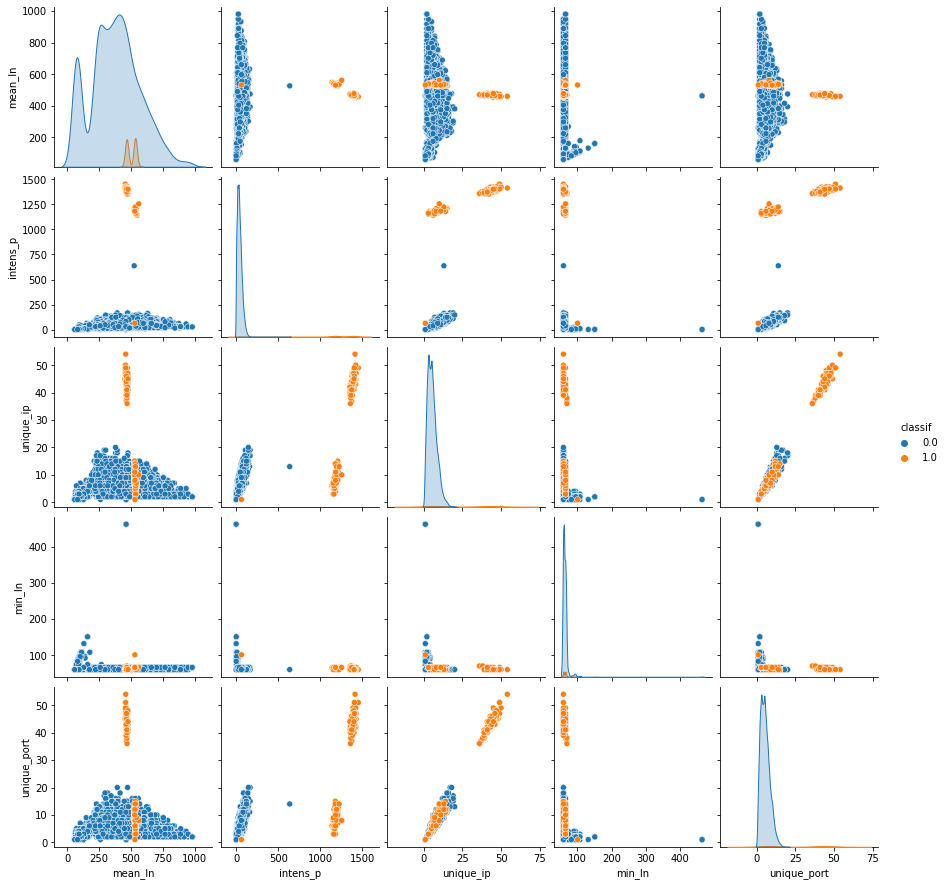

In [12]:
import seaborn as sns
cols = ['classif', 'mean_ln', 'intens_p', 'unique_ip', 'min_ln', 'unique_port']
sns_plot = sns.pairplot(df[cols], hue='classif')
# sns_plot.savefig('pairplot.png')

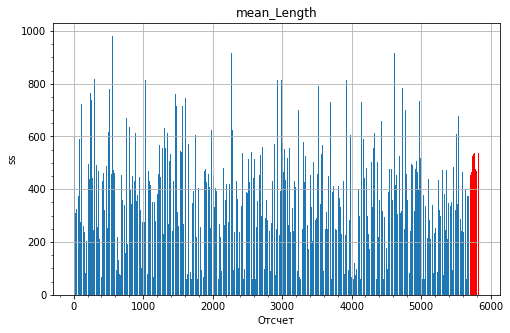

In [13]:
#mean_length
plt.subplot(111)
plt.bar(Number0, [x.mean_length for x in array_object_on_Interval0])
plt.bar(Number1, [x.mean_length for x in array_object_on_Interval1], color = 'r')
# plt.axis([0, len(array_object_on_Interval), 0, 1000])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('mean_Length')
plt.minorticks_on()

plt.grid()
# plt.savefig('./dns/agr2_step2/mean_length.png')
plt.show()



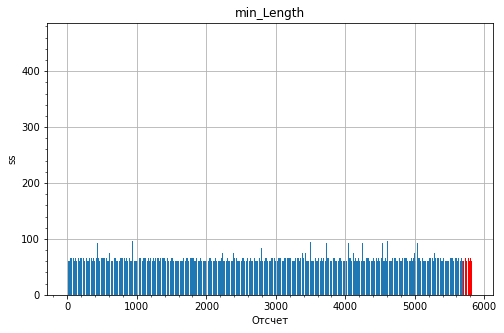

In [14]:
#min_length
plt.subplot(111)
plt.bar(Number0, [x.min_length for x in array_object_on_Interval0])
plt.bar(Number1, [x.min_length for x in array_object_on_Interval1], color = 'r')
# plt.axis([0, len(array_object_on_Interval), 0, 200])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('min_Length')
# plt.savefig('./dns/agr2_step2/min_ln.png')
plt.minorticks_on()

plt.grid()
plt.show()


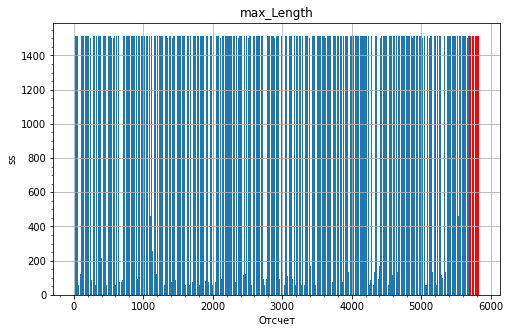

In [15]:
#max_length
plt.subplot(111)
plt.bar(Number0, [x.max_length for x in array_object_on_Interval0])
plt.bar(Number1, [x.max_length for x in array_object_on_Interval1], color='r')
# plt.axis([0, len(array_object_on_Interval), 0, 4000])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('max_Length')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/max_ln.png')
plt.show()

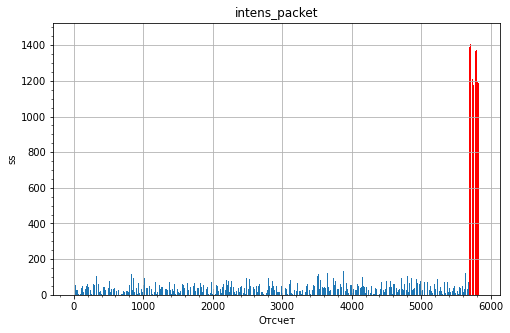

In [16]:
#intens -packet
plt.subplot(111)
plt.bar(Number0, [x.intens for x in array_object_on_Interval0])
plt.bar(Number1, [x.intens for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, intens1, color='r')
# plt.axis([0, len(array_object_on_Interval), 0, 300])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('intens_packet')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/intens_p.png')
plt.show()

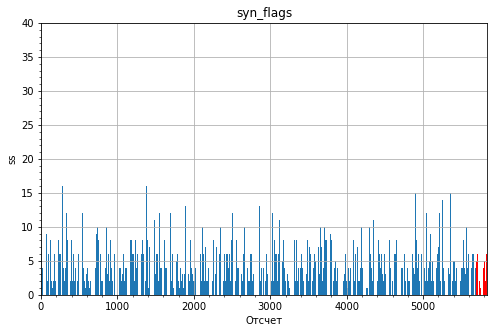

In [17]:
#syn_flags
plt.subplot(111)
plt.bar(Number0, [x.syn for x in array_object_on_Interval0])
plt.bar(Number1, [x.syn for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, syn1, color= 'r')
plt.axis([0, len(array_object_on_Interval), 0, 40])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('syn_flags')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/syn.png')
plt.show()

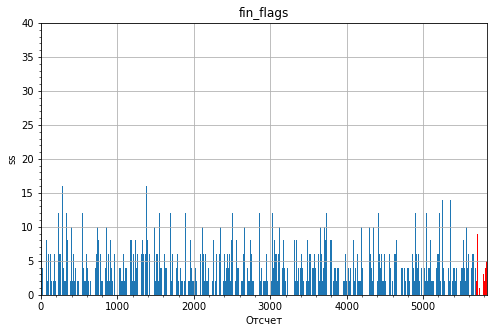

In [18]:
#fin_flags
plt.subplot(111)
plt.bar(Number0, [x.fin for x in array_object_on_Interval0])
plt.bar(Number1, [x.fin for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, syn1, color= 'r')
plt.axis([0, len(array_object_on_Interval), 0, 40])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('fin_flags')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/fin.png')
plt.show()

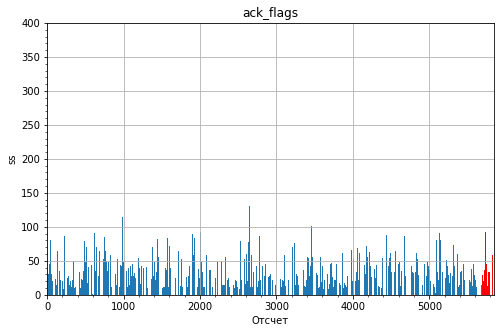

In [19]:
#ack_flags
plt.subplot(111)
plt.bar(Number0, [x.ack for x in array_object_on_Interval0])
plt.bar(Number1, [x.ack for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, syn1, color= 'r')
plt.axis([0, len(array_object_on_Interval), 0, 400])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('ack_flags')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/ack.png')
plt.show()

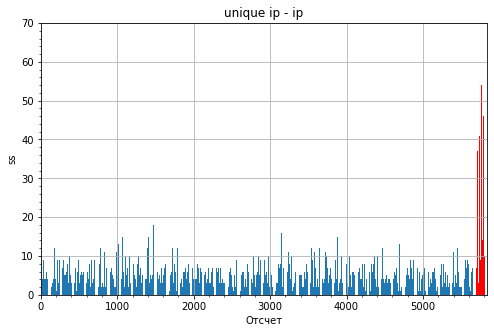

In [20]:
#unique ip-ip
plt.subplot(111)
plt.bar(Number0, [x.unique_ip for x in array_object_on_Interval0])
plt.bar(Number1, [x.unique_ip for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, unique1, color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('unique ip - ip')
plt.minorticks_on()
plt. axis([0, len(array_object_on_Interval), 0, 70])
plt.grid()
# plt.savefig('./dns/agr2_step2/unique_ip.png')
plt.show()

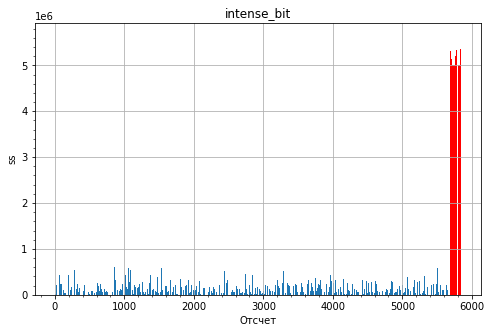

In [21]:
#intens_bit
plt.subplot(111)
plt.bar(Number0, [x.intens_bit for x in array_object_on_Interval0])
plt.bar(Number1, [x.intens_bit for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, bit1, color='r')
# plt.axis([0, len(array_object_on_Interval), 0, 400000])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('intense_bit')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/intens_bit.png')
plt.show()

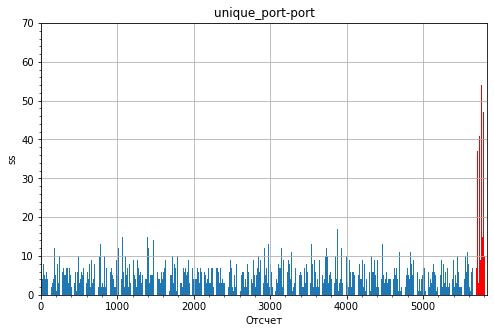

In [22]:
#unique_port
plt.subplot(111)
plt.bar(Number0, [x.unique_port for x in array_object_on_Interval0])
plt.bar(Number1, [x.unique_port for x in array_object_on_Interval1], color='r')
# plt.bar(NUMBER1, bit1, color='r')
plt.axis([0, len(array_object_on_Interval), 0, 70])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('unique_port-port')
plt.minorticks_on()
plt.grid()
# plt.savefig('./dns/agr2_step2/unique_port.png')
plt.show()

In [23]:
#### коэффициент ассметрии

def koef_assim(a):
    d = np.var(a, ddof=1)
    ka = (sum((xi - np.mean(a)) ** 3 for xi in a) / len(a)) / d ** 3
    if np.isnan(ka) or np.isinf(ka):
        return 0 
    return ka

#### коэффициент эксцесса

def koef_eksces(a):
    d = np.var(a, ddof=1)
    ke = ((sum((xi - np.mean(a)) ** 4 for xi in a) / len(a)) / d ** 4) - 3
    if np.isnan(ke) or np.isinf(ke):
        return 0 
    return ke

#### контрэксцесс

def kontrecsces(a):
    d = np.var(a, ddof=1)
    c = 1 / math.sqrt(scipy.stats.moment(a, moment=4) / (math.sqrt(d) ** 4))
    if np.isnan(c) or np.isinf(c):
        return 0
    return c
#### энтропийный коэффициент

def entr_koef(d, n, y, a):
    # n = len(a) число элементов в списке
    # m = int(10 + np.sqrt(n)) кол интервалов разбиения
    # d =(max(a)-min(a))/m длина интервалов
    h = 0.5 * d * n * 10 ** (-1 * (y * math.log10(y) / n))
    
#     h = 0.5 * d * n * 10 ** (-sum ([w * math.log10 (w) for w in y if w != 0]) / n)
    h = h / a
    if np.isnan(h) or np.isinf(h):
        return 0 
    return h

In [24]:
### создание класса для 4-х функций у каждого парамерта
class Default:
    def __init__(self, mean_ln_k_assim, mean_ln_k_eks, mean_ln_kontr, mean_ln_en_k,\
                min_ln_k_assim, min_ln_k_eks, min_ln_kontr, min_ln_en_k,\
                max_ln_k_assim, max_ln_k_eks, max_ln_kontr, max_ln_en_k,\
                intens_bit_k_assim, intens_bit_k_eks, intens_bit_kontr, intens_bit_en_k, \
                intens_p_k_assim, intens_p_k_eks, intens_p_kontr, intens_p_en_k,\
                unique_ip_k_assim, unique_ip_k_eks, unique_ip_kontr, unique_ip_en_k, \
                unique_port_k_assim, unique_port_k_eks, unique_port_kontr, unique_port_en_k, classific):
        self.mean_ln_k_assim = mean_ln_k_assim
        self.mean_ln_k_eks = mean_ln_k_eks
        self.mean_ln_kontr = mean_ln_kontr
        self.mean_ln_en_k = mean_ln_en_k
        
        self.min_ln_k_assim = min_ln_k_assim
        self.min_ln_k_eks = min_ln_k_eks
        self.min_ln_kontr = min_ln_kontr
        self.min_ln_en_k = min_ln_en_k
    
        self.max_ln_k_assim = max_ln_k_assim
        self.max_ln_k_eks = max_ln_k_eks
        self.max_ln_kontr = max_ln_kontr
        self.max_ln_en_k = max_ln_en_k
        
        self.intens_bit_k_assim = intens_bit_k_assim
        self.intens_bit_k_eks = intens_bit_k_eks
        self.intens_bit_kontr = intens_bit_kontr
        self.intens_bit_en_k = intens_bit_en_k
        
        self.intens_p_k_assim = intens_p_k_assim
        self.intens_p_k_eks = intens_p_k_eks
        self.intens_p_kontr = intens_p_kontr
        self.intens_p_en_k = intens_p_en_k
        
        self.unique_ip_k_assim = unique_ip_k_assim
        self.unique_ip_k_eks = unique_ip_k_eks
        self.unique_ip_kontr = unique_ip_kontr
        self.unique_ip_en_k = unique_ip_en_k
        
        self.unique_port_k_assim = unique_port_k_assim
        self.unique_port_k_eks = unique_port_k_eks
        self.unique_port_kontr = unique_port_kontr
        self.unique_port_en_k = unique_port_en_k
        
        self.classific = classific

#создание каждого объекта отдельно



In [25]:
import scipy.stats

def func2(k1, k2, array):
#     obj = Default(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
#     del obj
    f_mean_length = []
    f_min_len = []
    f_max_len = []
    f_intens_bit = []
    f_intens_p = []
    f_unique_ip = []
    f_unique_port = []
    f_class = []
    itog_cl = []
    for i in range(len(array)):
        if int(k1) <= int(i) <= int(k2):
            f_mean_length.append(array[i].mean_length)
            f_min_len.append(array[i].min_length)
            f_max_len.append(array[i].max_length)
            f_intens_bit.append(array[i].intens_bit)
            f_intens_p.append(array[i].intens)
            f_unique_ip.append(array[i].unique_ip)
            f_unique_port.append(array[i].unique_port) 
            f_class.append(array[i].classification)
    if len(f_mean_length) > 0:
        if len(f_class) == sum(f_class):
            itog_cl = 1
        else:
            itog_cl = 0
        obj = Default(koef_assim(f_mean_length), koef_eksces(f_mean_length), kontrecsces(f_mean_length),\
                      entr_koef(k2 - k1, len(f_mean_length), len(f_mean_length), np.std(f_mean_length)),\
                      koef_assim(f_min_len), koef_eksces(f_min_len), kontrecsces(f_min_len),\
                      entr_koef(k2 - k1, len(f_min_len), len(f_min_len), np.std(f_min_len)), \
                      koef_assim(f_max_len), koef_eksces(f_max_len), kontrecsces(f_max_len), \
                      entr_koef(k2 - k1, len(f_max_len), len(f_max_len), np.std(f_max_len)), \
                      koef_assim(f_intens_bit), koef_eksces(f_intens_bit), kontrecsces(f_intens_bit), \
                      entr_koef(k2 - k1, len(f_intens_bit), len(f_intens_bit), np.std(f_intens_bit)), \
                      koef_assim(f_intens_p), koef_eksces(f_intens_p), kontrecsces(f_intens_p), \
                      entr_koef(k2 - k1, len(f_intens_p), len(f_intens_p), np.std(f_intens_p)), \
                      koef_assim(f_unique_ip), koef_eksces(f_unique_ip), kontrecsces(f_unique_ip), \
                      entr_koef(k2 - k1, len(f_unique_ip), len(f_unique_ip), np.std(f_unique_ip)), \
                      koef_assim(f_unique_port), koef_eksces(f_unique_port), kontrecsces(f_unique_port), \
                      entr_koef(k2 - k1, len(f_unique_port), len(f_unique_port), np.std(f_unique_port)),\
                      itog_cl)            
            
    else:
        pass
#         obj = Default(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)
    f_mean_length.clear()
    f_min_len.clear()
    f_max_len.clear()
    f_intens_bit.clear()
    f_intens_p.clear()
    f_unique_ip.clear()
    f_unique_port.clear()
    f_class.clear()
    return obj
#     return mean_ln_k_assim, mean_ln_k_eks, mean_ln_kontr, mean_ln_en_k, \
# min_ln_k_assim, min_ln_k_eks, min_ln_kontr, min_ln_en_k,\
# max_ln_k_assim, max_ln_k_eks, max_ln_kontr, max_ln_en_k,\
# intens_bit_k_assim, intens_bit_k_eks, intens_bit_kontr, intens_bit_en_k, \
# intens_p_k_assim, intens_p_k_eks, intens_p_kontr, intens_p_en_k,\
# unique_ip_k_assim, unique_ip_k_eks, unique_ip_kontr, unique_ip_en_k, \
# unique_port_k_assim, unique_port_k_eks, unique_port_kontr, unique_port_en_k, itog_cl


#             mean_ln_k_assim = koef_assim(f_mean_length)
#             mean_ln_k_eks = koef_eksces(f_mean_length)
#             mean_ln_kontr = kontrecsces(f_mean_length)
#             mean_ln_en_k = entr_koef(k2 - k1, len(f_mean_length), len(f_mean_length), np.std(f_mean_length))
            
#             min_ln_k_assim = koef_assim(f_min_len)
#             min_ln_k_eks = koef_eksces(f_min_len)
#             min_ln_kontr = kontrecsces(f_min_len)
#             min_ln_en_k = entr_koef(k2 - k1, len(f_min_len), len(f_min_len), np.std(f_min_len))
            
#             max_ln_k_assim = koef_assim(f_max_len)
#             max_ln_k_eks = koef_eksces(f_max_len)
#             max_ln_kontr = kontrecsces(f_max_len)
#             max_ln_en_k = entr_koef(k2 - k1, len(f_max_len), len(f_max_len), np.std(f_max_len))
            
#             intens_bit_k_assim = koef_assim(f_intens_bit)
#             intens_bit_k_eks = koef_eksces(f_intens_bit)
#             intens_bit_kontr = kontrecsces(f_intens_bit)
#             intens_bit_en_k = entr_koef(k2 - k1, len(f_intens_bit), len(f_intens_bit), np.std(f_intens_bit))
            
#             intens_p_k_assim = koef_assim(f_intens_p)
#             intens_p_k_eks = koef_eksces(f_intens_p)
#             intens_p_kontr = kontrecsces(f_intens_p)
#             intens_p_en_k = entr_koef(k2 - k1, len(f_intens_p), len(f_intens_p), np.std(f_intens_p))
            
#             unique_ip_k_assim = koef_assim(f_unique_ip)
#             unique_ip_k_eks = koef_eksces(f_unique_ip)
#             unique_ip_kontr = kontrecsces(f_unique_ip)
#             unique_ip_en_k = entr_koef(k2 - k1, len(f_unique_ip), len(f_unique_ip), np.std(f_unique_ip))
            
#             unique_port_k_assim = koef_assim(f_unique_port)
#             unique_port_k_eks = koef_eksces(f_unique_port)
#             unique_port_kontr = kontrecsces(f_unique_port)
#             unique_port_en_k = entr_koef(k2 - k1, len(f_unique_port), len(f_unique_port), np.std(f_unique_port))
            
    


In [26]:
def fff(a1, a2, arr):
    ITOG_MAS = []
    c = len(arr)
    while a2 <= len(arr):
        if 0 <= a2 <= int(0.1*c):
            print(1 * '■' + 9 * '○')
        elif int(0.1*c) < a2 <= int(0.2*c):
            print(2 * '■' + 8 * '○')
        elif int(0.2*c) < a2 <= int(0.3*c):
            print(3 * '■' + 7 * '○')
        elif int(0.3*c) < a2 <= int(0.4*c):
            print(4 * '■' + 6 * '○')
        elif int(0.4*c) < a2 <= int(0.5*c):
            print(5 * '■' + 5 * '○')
        elif int(0.5*c) < a2 <= int(0.6*c):
            print(6 * '■' + 4 * '○')
        elif int(0.6*c) < a2 <= int(0.7*c):
            print(7 * '■' + 3 * '○')
        elif int(0.7*c) < a2 <= int(0.8*c):
            print(8 * '■' + 2 * '○')
        elif int(0.8*c) < a2 <= int(0.9*c):
            print(9 * '■' + 1 * '○')
        else:
            print(9 * '■' + 1 * '○')
#         print(a2)
        ITOG_MAS.append(func2(a1, a2, arr))
        a1, a2 = a1 + step2, a2 + step2
        dff = pd.DataFrame([[p.mean_ln_k_assim, p.mean_ln_k_eks, p.mean_ln_kontr, p.mean_ln_en_k,\
                        p.min_ln_k_assim, p.min_ln_k_eks, p.min_ln_kontr, p.min_ln_en_k, \
                        p.max_ln_k_assim, p.max_ln_k_eks, p.max_ln_kontr, p.max_ln_en_k, \
                        p.intens_p_k_assim, p.intens_p_k_eks, p.intens_p_kontr, p.intens_p_en_k,\
                        p.intens_bit_k_assim, p.intens_bit_k_eks, p.intens_bit_kontr, p.intens_bit_en_k,\
                        p.unique_port_k_assim, p.unique_port_k_eks, p.unique_port_kontr, p.unique_port_en_k,\
                        p.unique_ip_k_assim, p.unique_ip_k_eks, p.unique_ip_kontr, p.unique_ip_en_k, p.classific
                        ] for p in ITOG_MAS],
                      columns=['mean_ln_k_assim', 'mean_ln_k_eks', 'mean_ln_kontr', 'mean_ln_en_k',
                               'min_ln_k_assim', 'min_ln_k_eks', 'min_ln_kontr', 'min_ln_en_k',
                               'max_ln_k_assim', 'max_ln_k_eks', 'max_ln_kontr', 'max_ln_en_k',
                               'intens_p_k_assim', 'intens_p_k_eks', 'intens_p_kontr', 'intens_p_en_k',
                               'intens_bit_k_assim', 'intens_bit_k_eks', 'intens_bit_kontr', 'intens_bit_en_k',
                               'unique_ip_k_assim', 'unique_ip_k_eks', 'unique_ip_kontr', 'unique_ip_en_k',
                               'unique_port_k_assim', 'unique_port_k_eks', 'unique_port_kontr', 'unique_port_en_k',
                               'classif'])
#     ctypes.windll.user32.MessageBoxW(0, "last.csv is created", "Notify", 0)
    dff.to_csv('last.csv', sep=',', encoding='utf-8', index=False)
    print('csv created')
    return ITOG_MAS, dff
    

In [27]:
a1 = 0
a2 = int(input('Введите окно для анализа временного интервала = '))
step2 = int(input('Введите шаг окна = '))

itog_mas0 = []
NUM0 = []
itog_mas1 = []
NUM1 = []
l = fff(a1,a2,array_object_on_Interval)
k = l[0]
dff = l[1]
cnt = 0
for c in k:
    if c.classific == 0:
        itog_mas0.append(c)
        NUM0.append(cnt)
    else:
        itog_mas1.append(c)
        NUM1.append(cnt)
    cnt += 1
    
print(f'интервал = {a2}')
print(f'шаг = {step2}')
print(f'Объектов с классом 0 : {len(itog_mas0)}')
print(f'Объектов с классом 1 : {len(itog_mas1)}')
# print(len(dff))

Введите окно для анализа временного интервала = 3
Введите шаг окна = 1
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○


<ipython-input-23-4fddea28fba0>:5: RuntimeWarning: invalid value encountered in double_scalars
  ka = (sum((xi - np.mean(a)) ** 3 for xi in a) / len(a)) / d ** 3
<ipython-input-23-4fddea28fba0>:14: RuntimeWarning: invalid value encountered in double_scalars
  ke = ((sum((xi - np.mean(a)) ** 4 for xi in a) / len(a)) / d ** 4) - 3
<ipython-input-23-4fddea28fba0>:23: RuntimeWarning: invalid value encountered in double_scalars
  c = 1 / math.sqrt(scipy.stats.moment(a, moment=4) / (math.sqrt(d) ** 4))
<ipython-input-23-4fddea28fba0>:36: RuntimeWarning: divide by zero encountered in double_scalars
  h = h / a


■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○
■○○○○○○○○○

■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○
■■○○○○○○○○

■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○
■■■○○○○○○○

■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■○○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○
■■■■■○○○○○

■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○
■■■■■■○○○○

■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○
■■■■■■■○○○

■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○
■■■■■■■■○○

■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○
■■■■■■■■■○

In [36]:

# for i in k:
#     print(i.mean_ln_k_assim)

# f_mean_length = [x.mean_length for x in array_object_on_Interval]
# f_min_length = [x.min_length for x in array_object_on_Interval]
# f_max_length = [x.max_length for x in array_object_on_Interval]
# f_intens_p = [x.intens for x in array_object_on_Interval]
# f_intens_bit = [x.intens_bit for x in array_object_on_Interval]
# f_unique_ip = [x.unique_ip for x in array_object_on_Interval]
# f_unique_port = [x.unique_port for x in array_object_on_Interval]
# f_class = [x.classification for x in array_object_on_Interval]
print(dff)

       mean_ln_k_assim  mean_ln_k_eks  mean_ln_kontr  mean_ln_en_k  \
0        -1.139639e-04      -2.999989       0.886559      0.094865   
1         3.573472e-08      -3.000000       0.874902      0.006307   
2         5.271334e-09      -3.000000       0.934190      0.004698   
3         5.928508e-09      -3.000000       0.978155      0.004098   
4         6.259932e-09      -3.000000       0.967605      0.004103   
...                ...            ...            ...           ...   
14501     0.000000e+00       0.000000       0.000000      0.000000   
14502     0.000000e+00       0.000000       0.000000      0.000000   
14503     0.000000e+00       0.000000       0.000000      0.000000   
14504     0.000000e+00       0.000000       0.000000      0.000000   
14505     0.000000e+00       0.000000       0.000000      0.000000   

       min_ln_k_assim  min_ln_k_eks  min_ln_kontr  min_ln_en_k  \
0            0.000000     -2.996094      1.333333     0.500000   
1           -0.027778     -

ГРАФИКИ ДЛЯ СРЕДНЕЙ ДЛИНЫ ПАКЕТА


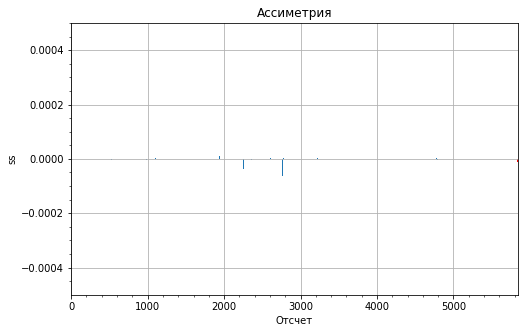

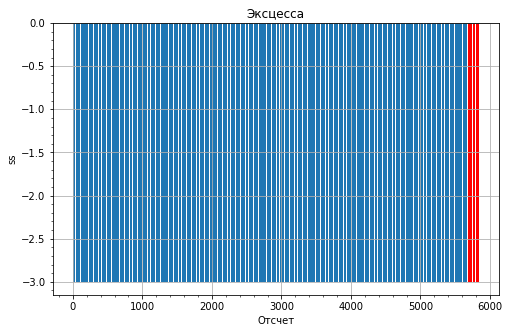

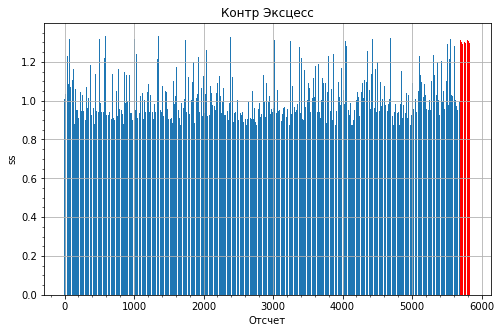

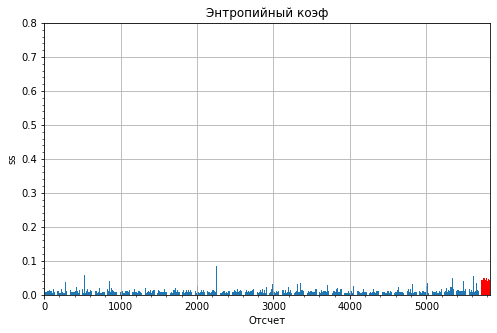

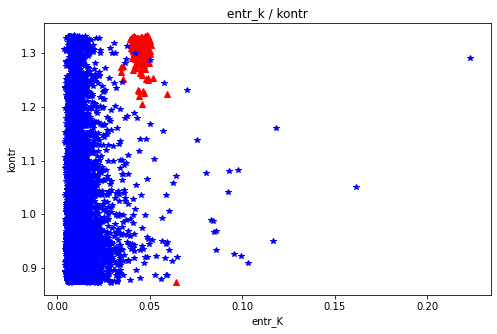

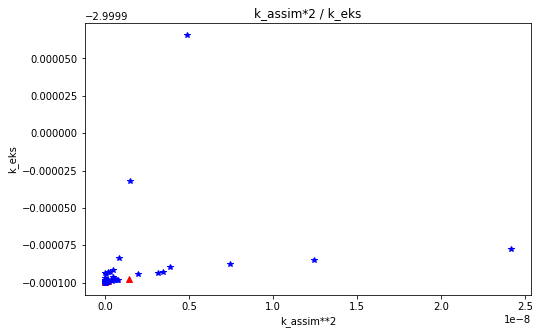

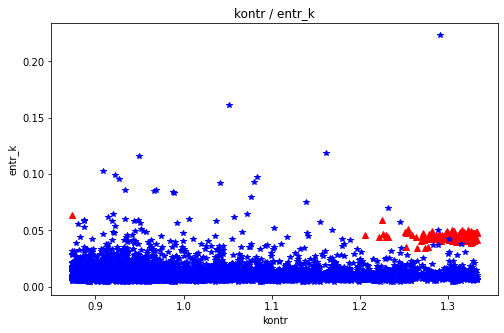

'3DPlot.html'

In [28]:
print ('ГРАФИКИ ДЛЯ СРЕДНЕЙ ДЛИНЫ ПАКЕТА')

#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.mean_ln_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.mean_ln_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.0005, 0.0005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.mean_ln_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.mean_ln_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM0, [c.mean_ln_kontr for c in itog_mas0])
plt.bar(NUM1, [c.mean_ln_kontr for c in itog_mas1], color='r')
# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.mean_ln_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.mean_ln_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
plt.axis([0, len(NUM0) + len(NUM1), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.mean_ln_en_k for c in itog_mas1], [c.mean_ln_kontr for c in itog_mas1] , 'r^')
plt.plot([c.mean_ln_en_k for c in itog_mas0], [c.mean_ln_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.mean_ln_k_assim**2 for c in itog_mas1], [c.mean_ln_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.mean_ln_k_assim**2 for c in itog_mas0], [c.mean_ln_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.mean_ln_kontr for c in itog_mas1], [c.mean_ln_en_k for c in itog_mas1] , 'r^')
plt.plot([c.mean_ln_kontr for c in itog_mas0], [c.mean_ln_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.mean_ln_en_k for c in itog_mas0], y=[c.mean_ln_k_assim for c in itog_mas0],\
                    z=[c.mean_ln_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.mean_ln_en_k for c in itog_mas1], y=[c.mean_ln_k_assim for c in itog_mas1],\
                    z=[c.mean_ln_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))


vvedite_nazv_mas: mean_ln


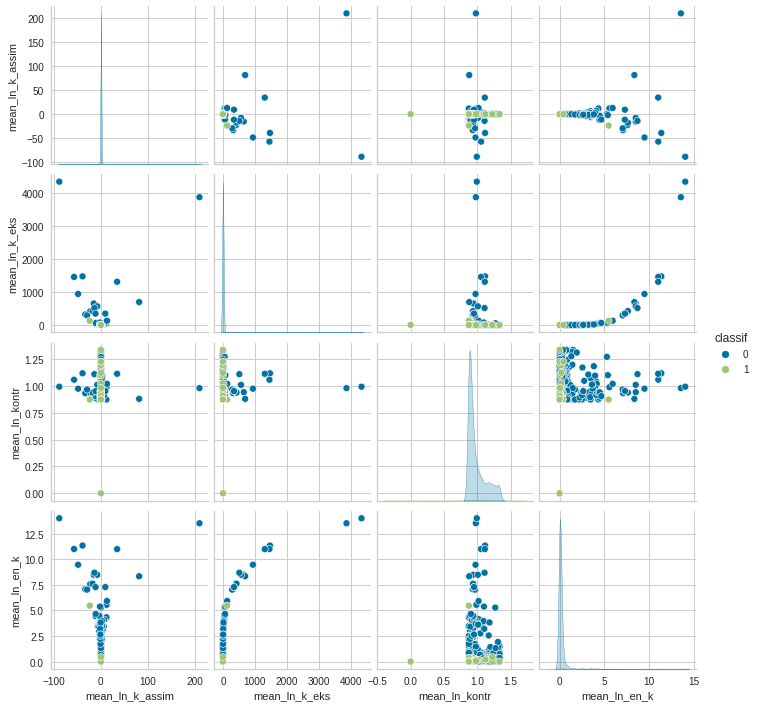

In [92]:
import seaborn as sns
mas = input('vvedite_nazv_mas: ')
assim = mas + '_k_assim'
eks = mas +'_k_eks'
kontr = mas +'_kontr'
en_k = mas + '_en_k'
cols = [assim, eks, kontr, en_k, 'classif']
# cols = ['mean_ln_k_assim', 'mean_ln_en_k', 'unique_port_k_assim', 'unique_port_en_k','classif']
sns_plot = sns.pairplot(dff[cols], hue='classif')
# sns_plot.savefig('./dns/agr2_step2/agr4_step1/pairplot_unique_port.png')

ГРАФИКИ ДЛЯ МАКСИМАЛЬНОЙ ДЛИНЫ ПАКЕТА


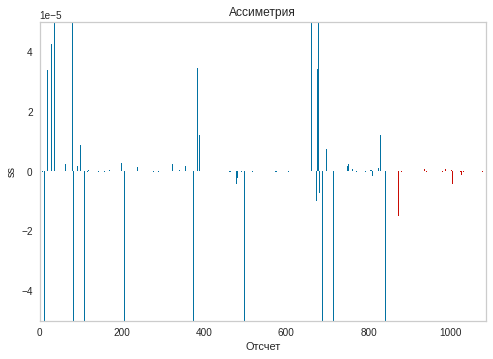

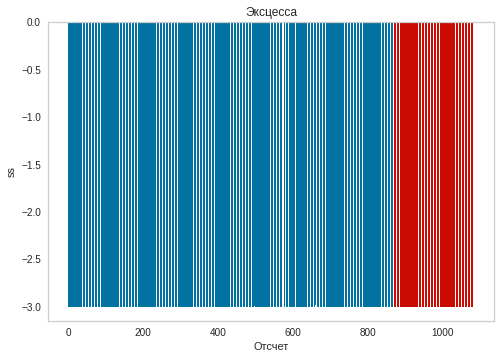

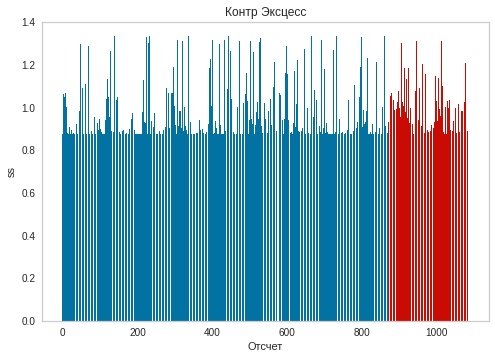

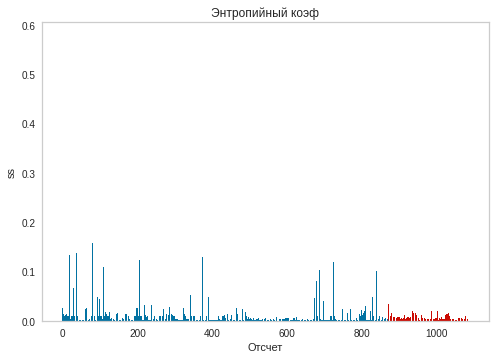

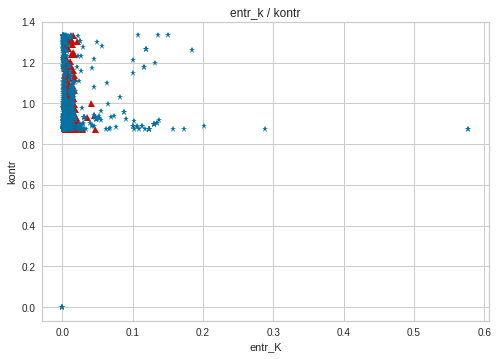

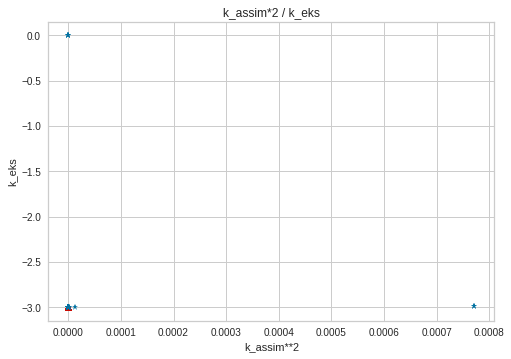

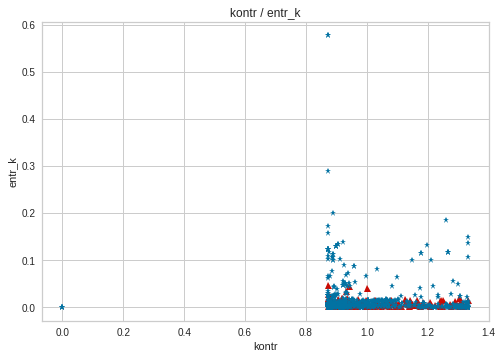

'3DPlot.html'

In [63]:
print ('ГРАФИКИ ДЛЯ МАКСИМАЛЬНОЙ ДЛИНЫ ПАКЕТА')

#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.max_ln_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.max_ln_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.max_ln_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.max_ln_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.max_ln_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.max_ln_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.max_ln_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.max_ln_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.max_ln_en_k for c in itog_mas1], [c.max_ln_kontr for c in itog_mas1] , 'r^')
plt.plot([c.max_ln_en_k for c in itog_mas0], [c.max_ln_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.max_ln_k_assim**2 for c in itog_mas1], [c.max_ln_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.max_ln_k_assim**2 for c in itog_mas0], [c.max_ln_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.max_ln_kontr for c in itog_mas1], [c.max_ln_en_k for c in itog_mas1] , 'r^')
plt.plot([c.max_ln_kontr for c in itog_mas0], [c.max_ln_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.max_ln_en_k for c in itog_mas0], y=[c.max_ln_k_assim for c in itog_mas0],\
                    z=[c.max_ln_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.max_ln_en_k for c in itog_mas1], y=[c.max_ln_k_assim for c in itog_mas1],\
                    z=[c.max_ln_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))


ГРАФИКИ ДЛЯ МИНИМАЛЬНОЙ ДЛИНЫ ПАКЕТА


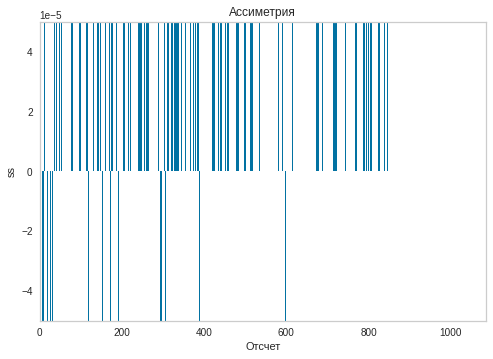

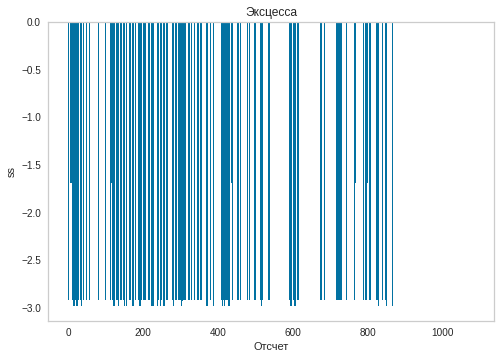

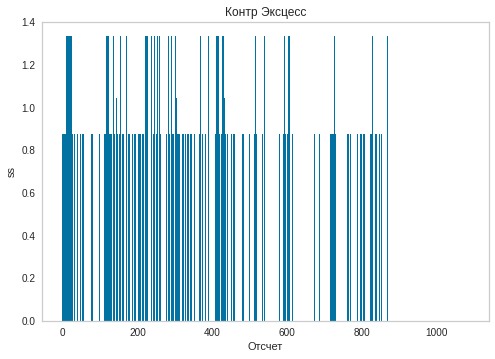

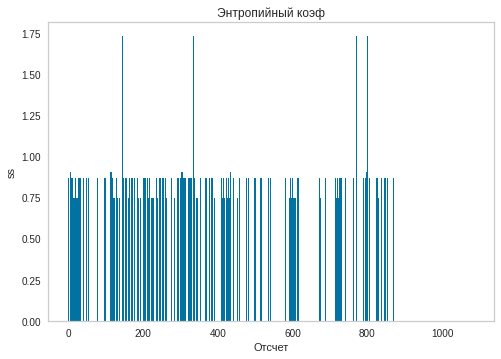

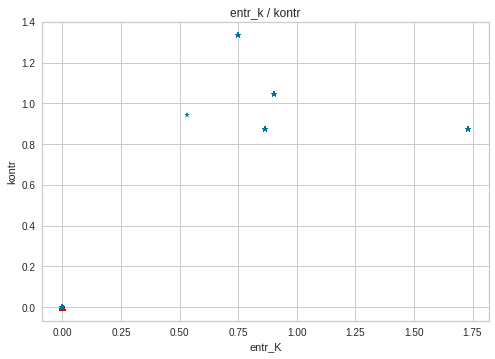

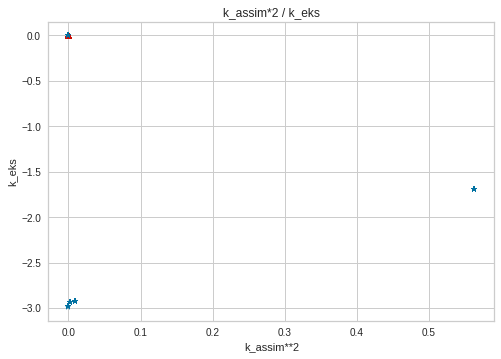

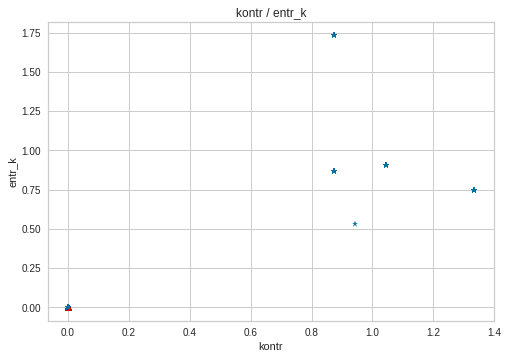

'3DPlot.html'

In [64]:
print ('ГРАФИКИ ДЛЯ МИНИМАЛЬНОЙ ДЛИНЫ ПАКЕТА')

#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.min_ln_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.min_ln_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.min_ln_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.min_ln_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.min_ln_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.min_ln_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.min_ln_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.min_ln_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.min_ln_en_k for c in itog_mas1], [c.min_ln_kontr for c in itog_mas1] , 'r^')
plt.plot([c.min_ln_en_k for c in itog_mas0], [c.min_ln_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.min_ln_k_assim**2 for c in itog_mas1], [c.min_ln_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.min_ln_k_assim**2 for c in itog_mas0], [c.min_ln_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.min_ln_kontr for c in itog_mas1], [c.min_ln_en_k for c in itog_mas1] , 'r^')
plt.plot([c.min_ln_kontr for c in itog_mas0], [c.min_ln_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.min_ln_en_k for c in itog_mas0], y=[c.min_ln_k_assim for c in itog_mas0],\
                    z=[c.min_ln_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.min_ln_en_k for c in itog_mas1], y=[c.min_ln_k_assim for c in itog_mas1],\
                    z=[c.min_ln_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))


ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ АДРЕСОВ АЙПИ ПАКЕТА


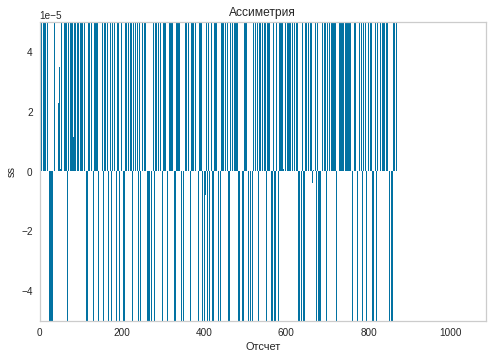

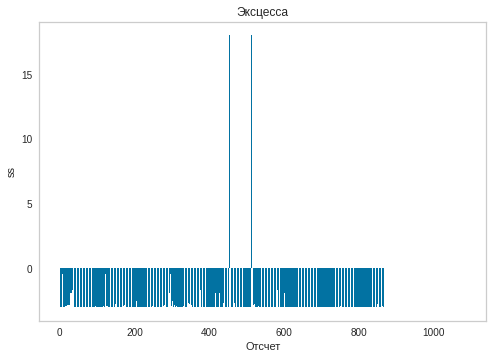

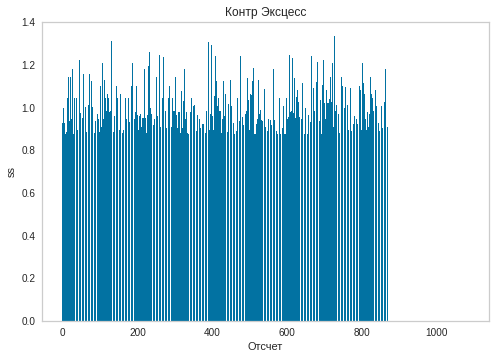

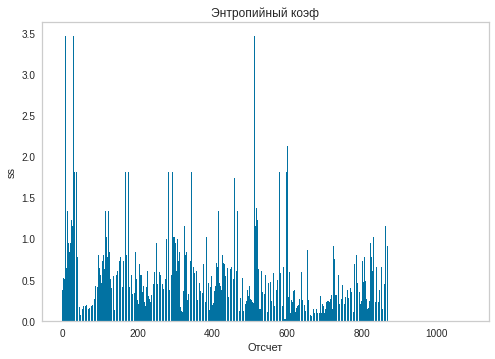

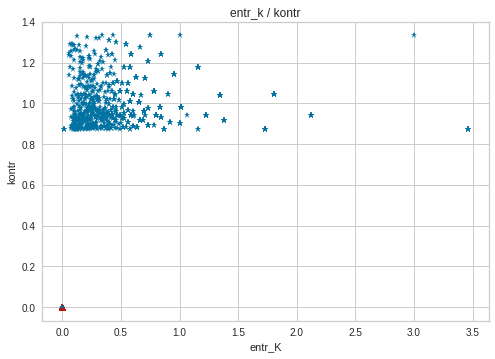

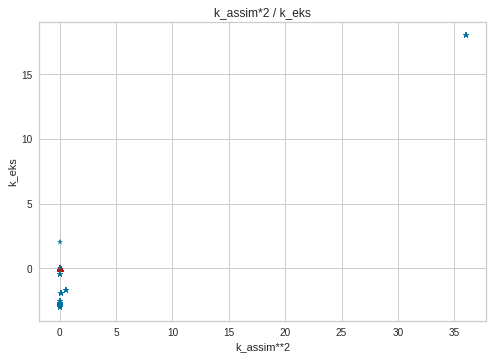

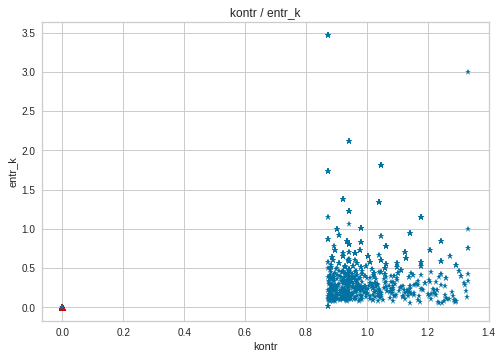

'3DPlot.html'

In [65]:
print ('ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ АДРЕСОВ АЙПИ ПАКЕТА')


#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.unique_ip_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_ip_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.unique_ip_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_ip_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.unique_ip_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_ip_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.unique_ip_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_ip_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.unique_ip_en_k for c in itog_mas1], [c.unique_ip_kontr for c in itog_mas1] , 'r^')
plt.plot([c.unique_ip_en_k for c in itog_mas0], [c.unique_ip_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.unique_ip_k_assim**2 for c in itog_mas1], [c.unique_ip_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.unique_ip_k_assim**2 for c in itog_mas0], [c.unique_ip_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.unique_ip_kontr for c in itog_mas1], [c.unique_ip_en_k for c in itog_mas1] , 'r^')
plt.plot([c.unique_ip_kontr for c in itog_mas0], [c.unique_ip_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.unique_ip_en_k for c in itog_mas0], y=[c.unique_ip_k_assim for c in itog_mas0],\
                    z=[c.unique_ip_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.unique_ip_en_k for c in itog_mas1], y=[c.unique_ip_k_assim for c in itog_mas1],\
                    z=[c.unique_ip_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))


ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ ПОРТОВ АЙПИ ПАКЕТА


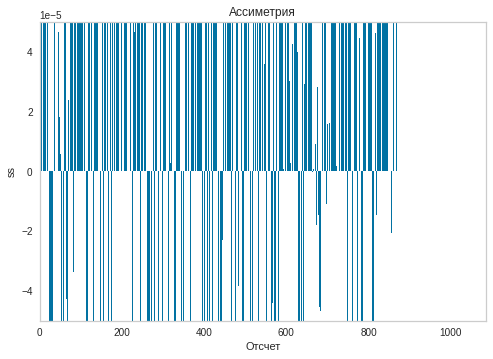

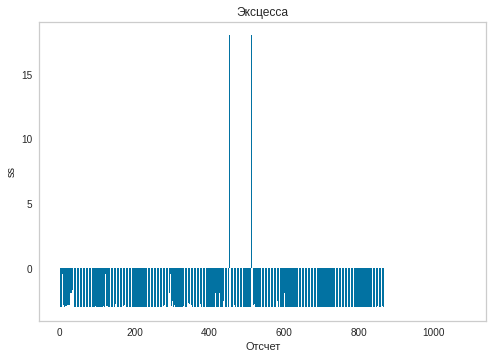

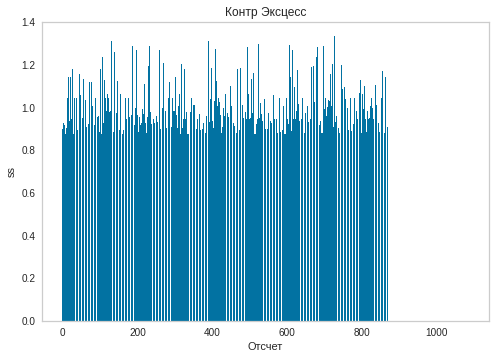

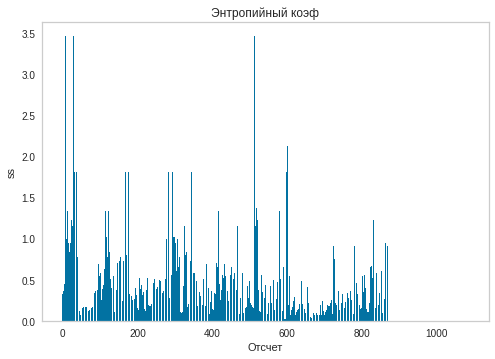

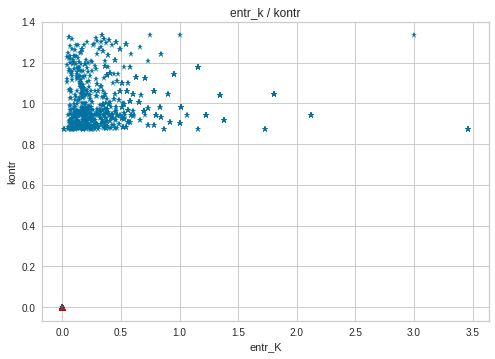

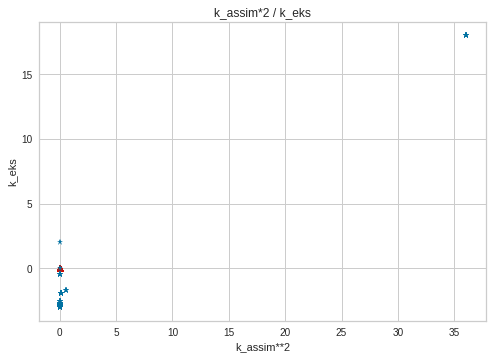

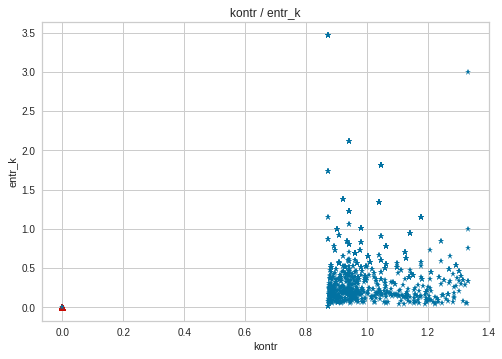

'3DPlot.html'

In [66]:
print ('ГРАФИКИ ДЛЯ УНИКАЛЬНЫХ ПОРТОВ АЙПИ ПАКЕТА')


#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.unique_port_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_port_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.unique_port_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_port_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.unique_port_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_port_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.unique_port_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.unique_port_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.unique_port_en_k for c in itog_mas1], [c.unique_port_kontr for c in itog_mas1] , 'r^')
plt.plot([c.unique_port_en_k for c in itog_mas0], [c.unique_port_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.unique_port_k_assim**2 for c in itog_mas1], [c.unique_port_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.unique_port_k_assim**2 for c in itog_mas0], [c.unique_port_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.unique_port_kontr for c in itog_mas1], [c.unique_port_en_k for c in itog_mas1] , 'r^')
plt.plot([c.unique_port_kontr for c in itog_mas0], [c.unique_port_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.unique_port_en_k for c in itog_mas0], y=[c.unique_port_k_assim for c in itog_mas0],\
                    z=[c.unique_port_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.unique_port_en_k for c in itog_mas1], y=[c.unique_port_k_assim for c in itog_mas1],\
                    z=[c.unique_port_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))


ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ ПАКЕТ


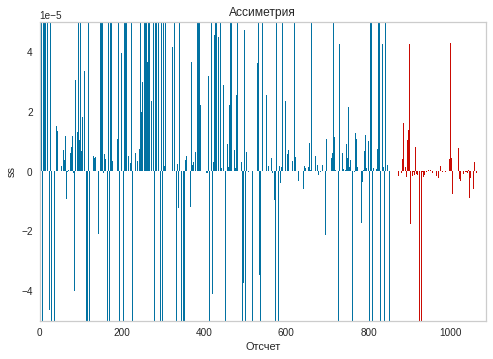

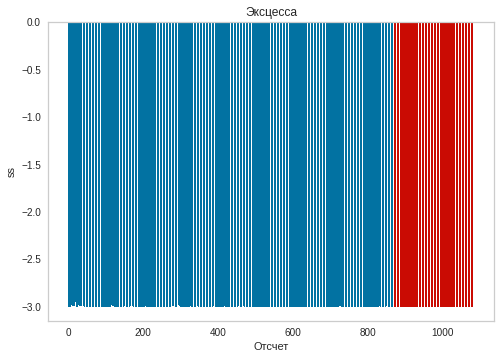

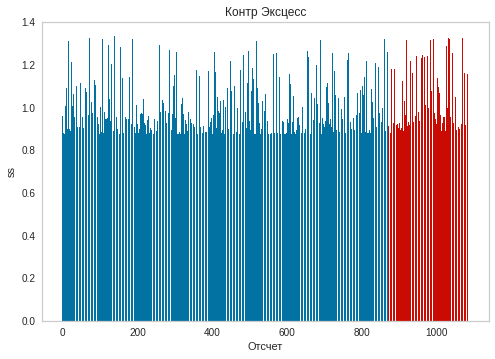

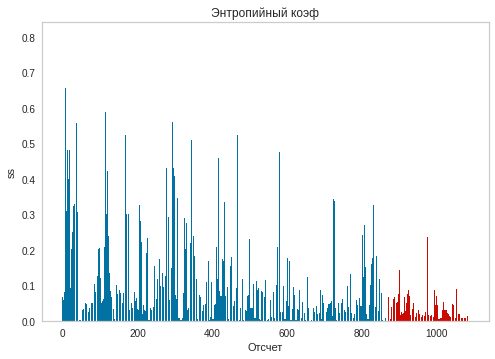

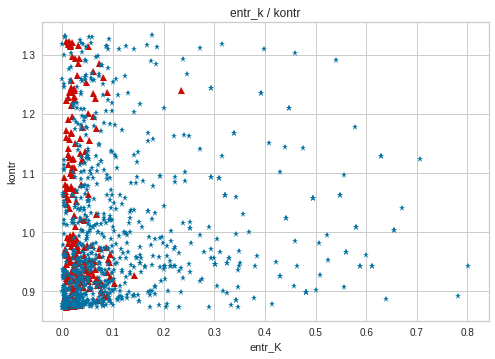

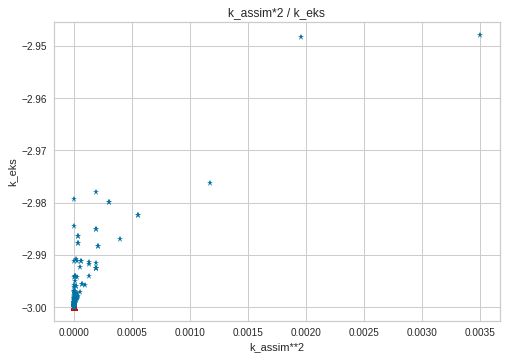

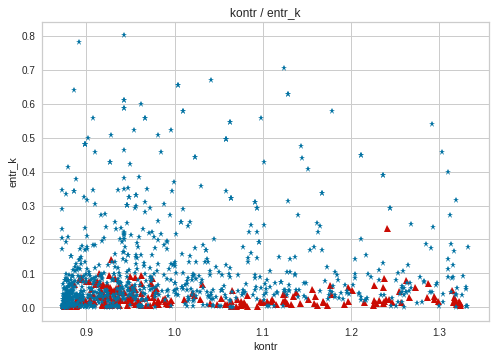

'3DPlot.html'

In [67]:
print ('ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ ПАКЕТ')

#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.intens_p_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_p_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.intens_p_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_p_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.intens_p_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_p_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.intens_p_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_p_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.intens_p_en_k for c in itog_mas1], [c.intens_p_kontr for c in itog_mas1] , 'r^')
plt.plot([c.intens_p_en_k for c in itog_mas0], [c.intens_p_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.intens_p_k_assim**2 for c in itog_mas1], [c.intens_p_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.intens_p_k_assim**2 for c in itog_mas0], [c.intens_p_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.intens_p_kontr for c in itog_mas1], [c.intens_p_en_k for c in itog_mas1] , 'r^')
plt.plot([c.intens_p_kontr for c in itog_mas0], [c.intens_p_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.intens_p_en_k for c in itog_mas0], y=[c.intens_p_k_assim for c in itog_mas0],\
                    z=[c.intens_p_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.intens_p_en_k for c in itog_mas1], y=[c.intens_p_k_assim for c in itog_mas1],\
                    z=[c.intens_p_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=False,
                     filename=("3DPlot.html"))





ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ БИТ


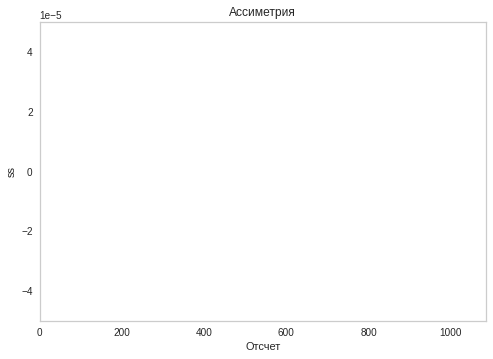

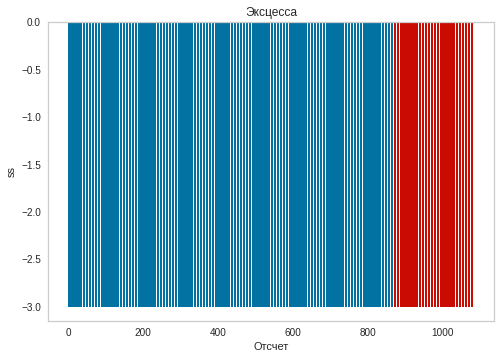

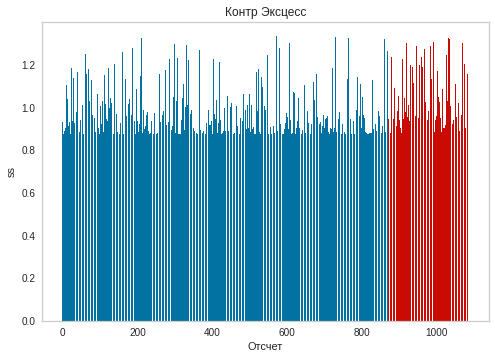

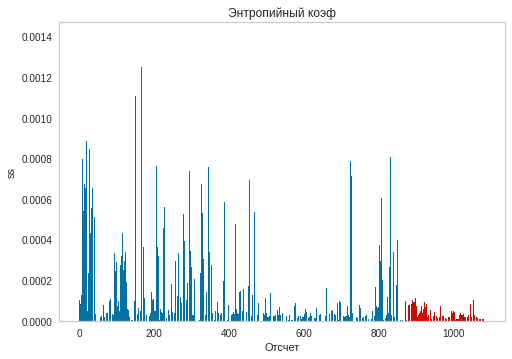

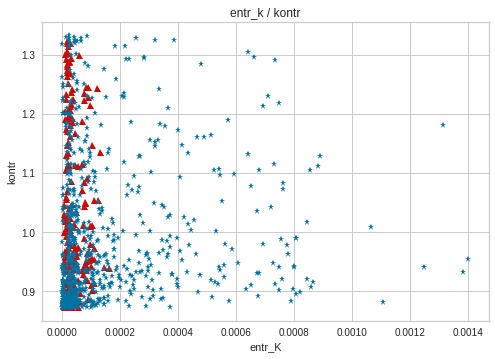

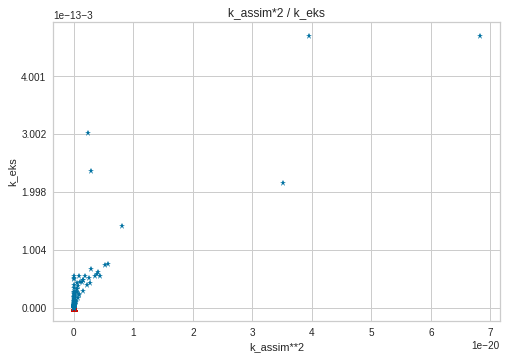

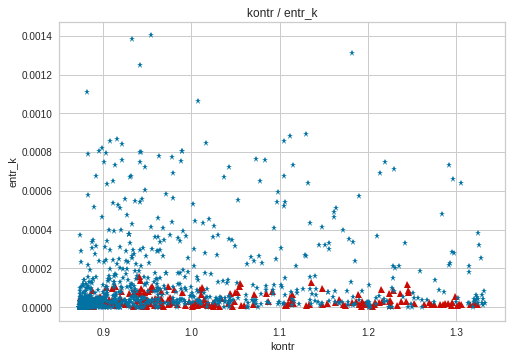

'3DPlot.html'

In [68]:
print ('ГРАФИКИ ДЛЯ ИНТЕНСИВНОСТИ БИТ')

#ассиметрия
plt.subplot(111)
plt.bar(NUM1, [c.intens_bit_k_assim for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_bit_k_assim for c in itog_mas0])

plt.axis([0, len(NUM0) + len(NUM1), -0.00005, 0.00005])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Ассиметрия')
plt.minorticks_on()
plt.grid()
plt.show()
# #
#эксцесс
# print(k_ek_ln)
plt.subplot(111)
plt.bar(NUM1, [c.intens_bit_k_eks for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_bit_k_eks for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[9], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Эксцесса')
plt.minorticks_on()
plt.grid()
plt.show()
#
# #контрэксцесс
# #
plt.subplot(111)
plt.bar(NUM1, [c.intens_bit_kontr for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_bit_kontr for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[10], color='r')
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Контр Эксцесс')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтропийный коэф
# #
plt.subplot(111)
plt.bar(NUM1, [c.intens_bit_en_k for c in itog_mas1], color='r')
plt.bar(NUM0, [c.intens_bit_en_k for c in itog_mas0])

# plt.bar(fff(a1, a2, mean_length)[13], fff(a1, a2, mean_length)[11], color='r')
# plt.axis([0, len(range(len(k))), 0, 0.8])
plt.xlabel('Отсчет')
plt.ylabel('ss')
plt.title('Энтропийный коэф')
plt.minorticks_on()
plt.grid()
plt.show()
# #
# #энтр коэф \ контр
# #
plt.subplot(111)
plt.title('entr_k / kontr')
plt.plot([c.intens_bit_en_k for c in itog_mas1], [c.intens_bit_kontr for c in itog_mas1] , 'r^')
plt.plot([c.intens_bit_en_k for c in itog_mas0], [c.intens_bit_kontr for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[11], fff(a1, a2, mean_length)[10], 'r^')
plt.xlabel('entr_K')
plt.ylabel('kontr')
plt.show()
# #
# #ассим \ экс
# #
plt.subplot(111)
plt.title('k_assim*2 / k_eks')
plt.plot( [c.intens_bit_k_assim**2 for c in itog_mas1], [c.intens_bit_k_eks for c in itog_mas1], 'r^')
plt.plot( [c.intens_bit_k_assim**2 for c in itog_mas0], [c.intens_bit_k_eks for c in itog_mas0], 'b*')

# plt.plot([k**2 for k in fff(a1, a2, mean_length)[8]], fff(a1, a2, mean_length)[9], 'r^')
plt.xlabel('k_assim**2')
plt.ylabel('k_eks')
plt.show()
# #
# #kont/entr
# #

plt.subplot(111)
plt.title('kontr / entr_k')
plt.xlabel('kontr')
plt.ylabel('entr_k')
plt.plot([c.intens_bit_kontr for c in itog_mas1], [c.intens_bit_en_k for c in itog_mas1] , 'r^')
plt.plot([c.intens_bit_kontr for c in itog_mas0], [c.intens_bit_en_k for c in itog_mas0] , 'b*')

# plt.plot(fff(a1, a2, mean_length)[10], fff(a1, a2, mean_length)[11], 'r^')
plt.show()
# #
import plotly.graph_objs as go
import plotly
fig1 = go.Scatter3d(x=[c.intens_bit_en_k for c in itog_mas0], y=[c.intens_bit_k_assim for c in itog_mas0],\
                    z=[c.intens_bit_kontr for c in itog_mas0],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
fig2 = go.Scatter3d(x=[c.intens_bit_en_k for c in itog_mas1], y=[c.intens_bit_k_assim for c in itog_mas1],\
                    z=[c.intens_bit_kontr for c in itog_mas1],\
                    marker=dict(opacity=0.9, reversescale=True,size=5),\
                    line=dict(width=0.2), mode='markers')
mylayout = go.Layout(scene=dict(xaxis=dict( title="entr_k"),
                                yaxis=dict( title="k_assim"),
                                zaxis=dict(title="kontr")),)

#Plot and save html
plotly.offline.plot({"data": [fig1, fig2],
                     "layout": mylayout},
                     auto_open=True,
                     filename=("3DPlot.html"))





# ИСПОЛЬЗОВАНИЕ PYCARET
СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ


In [29]:
from pycaret.classification import *
# from pycaret.anomaly import *
from sklearn.utils import shuffle
# dff = pd.read_csv('last.csv')
dataset = dff
dataset = shuffle(dataset)
# print(dataset)

# print(dataset.shape)
data = dataset.sample(frac=0.6, random_state=1234567)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

exp1 = setup(dff, target="classif")
compare_models(fold=7)


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=202, verbose=0,
                     warm_start=False)

# ПРОВЕРКА SVM 

SGDClassifier(alpha=0.0005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.5, fit_intercept=False,
              l1_ratio=0.9700000001, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1,
              penalty='elasticnet', power_t=0.5, random_state=202, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=0, warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

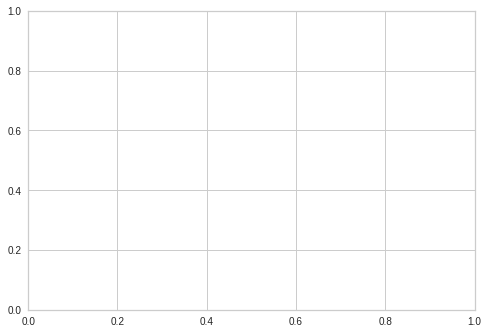

In [30]:
svm1 = create_model('svm', fold=7)
svm1 = tune_model(svm1)
# bagged_svm1 = ensemble_model(svm1)
print(svm1)
evaluate_model(svm1)

In [33]:
svm2 = create_model('svm', cross_validation=True)
svm2 = tune_model(svm2)
bagged_svm = ensemble_model(svm2)
print(svm2)

SGDClassifier(alpha=0.0005, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=False,
              l1_ratio=0.5800000001, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=495, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [31]:
svm_pred = predict_model(svm1)

# ПРОВЕРКА RANDOM FOREST



In [33]:
rf = create_model('rf', cross_validation=True)
rf = tune_model(rf)
bagged_rf = ensemble_model(rf)
# print(bagged_rf)
evaluate_model(rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [36]:
rf = create_model('rf',fold=4)
rf = tune_model(rf)
bagged_rf = ensemble_model(rf)
print(rf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=8, max_features='sqrt', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.005,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=5, min_weight_fraction_leaf=0.0,
                       n_estimators=60, n_jobs=-1, oob_score=False,
                       random_state=495, verbose=0, warm_start=False)


In [34]:
rf_pred = predict_model(rf)

# ПРОВЕРКА KNN

In [35]:
knn = create_model('knn',fold=5)
knn = tune_model(knn)
bagged_knn = ensemble_model(knn)
print(knn)
evaluate_model(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=-1, n_neighbors=32, p=2,
                     weights='distance')


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [36]:
knn_pred = predict_model(knn)

# TREE OF DECISION

In [38]:
td = create_model('dt')
td = tune_model(td)
bagged_td = ensemble_model(td)
print(td)
evaluate_model(td)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=1.0, max_leaf_nodes=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=202, splitter='best')


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [39]:
td_pred = predict_model(td)

In [ ]:

# train logistic regression model
lr = create_model('lr') #lr is the id of the model
# train rf model using 5 fold CV
rf = create_model('rf', fold = 5)
# train svm model without CV
svm = create_model('svm', cross_validation = False)

# train multiple lightgbm models with n learning_rate<br>import numpy as np
lgbms = [create_model('lightgbm', learning_rate = i) for i in np.arange(0.1,1,0.1)]
# train custom model
from gplearn.genetic import SymbolicClassifier
symclf = SymbolicClassifier(generation = 50)
sc = create_model(symclf)

In [ ]:
dataset = dff
dataset.shape

data = dataset.sample(frac=0.8, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

In [ ]:
exp_ano101 = setup(data, normalize = True, session_id = 123)

In [ ]:
svm = create_model('svm')
print(svm)

In [27]:
from pycaret.anomaly import *
svm_result = assign_model(svm)
plot_model(svm)

In [32]:
plot_model(svm, plot ='umap')

In [30]:
unseen_predections = predict_model(svm, data=data_unseen)
unseen_predections[50:70]

mean_ln_k_assim  mean_ln_k_eks  mean_ln_kontr  mean_ln_en_k  \
50    -7.455030e-08           -3.0       0.823134      0.011899   
51     1.974158e-08           -3.0       0.985215      0.011413   
52    -7.702989e-08           -3.0       0.840422      0.013096   
53    -2.544849e-07           -3.0       0.712525      0.014331   
54    -5.289156e-09           -3.0       0.815887      0.007983   
55    -8.272947e-08           -3.0       0.990549      0.014214   
56    -1.085270e-07           -3.0       0.941400      0.016883   
57     8.464411e-09           -3.0       0.995760      0.006399   
58     9.718037e-08           -3.0       1.122549      0.019107   
59     6.997266e-09           -3.0       1.112255      0.008070   
60    -2.488607e-08           -3.0       0.957513      0.008859   
61     8.097322e-09           -3.0       1.061531      0.008244   
62    -2.765049e-08           -3.0       0.930755      0.009222   
63    -1.188843e-08           -3.0       1.128243      0.009014   
64     3.238817e-08           -3.0       1.019243      0.009707   
65    -1.501258e-09           -3.0       1.028020      0.010444   
66     7.206013e-09           -3.0       1.125832      0.007739   
67    -3.175565e-08           -3.0       0.804160      0.008083   
68     9.174341e-09           -3.0       1.025507      0.009784   
69     8.351451e-08           -3.0       0.791305      0.011247   

    min_ln_k_assim  min_ln_k_eks  min_ln_kontr  min_ln_en_k  max_ln_k_assim  \
50        0.001171     -2.999737      0.744918     0.245737   -4.429890e-09   
51       -0.008230     -2.993599      1.157275     0.680414   -5.783414e-10   
52       -0.055556     -2.959877      0.693375     0.833333   -3.903804e-09   
53       -0.008230     -2.993599      1.157275     0.680414   -3.903804e-09   
54        0.055556     -2.959877      0.693375     0.833333   -3.903804e-09   
55        0.008230     -2.993599      1.157275     0.680414   -1.376966e-09   
56        0.008230     -2.993599      1.157275     0.680414    0.000000e+00   
57       -0.008230     -2.993599      1.157275     0.680414   -5.783414e-10   
58       -0.008230     -2.993599      1.157275     0.680414    3.528046e-10   
59       -0.055556     -2.959877      0.693375     0.833333   -1.418349e-09   
60       -0.055556     -2.959877      0.693375     0.833333   -4.208744e-09   
61       -0.008230     -2.993599      1.157275     0.680414   -6.208991e-10   
62       -0.008230     -2.993599      1.157275     0.680414   -4.173327e-09   
63        0.055556     -2.959877      0.693375     0.833333   -5.986014e-10   
64        0.000492     -2.999926      0.693375     0.172414    6.059482e-10   
65        0.000488     -2.999923      0.718984     0.177892   -6.040502e-10   
66        0.002974     -2.998966      0.818236     0.362738   -6.132538e-10   
67        0.008230     -2.993599      1.157275     0.680414   -3.903804e-09   
68       -0.008230     -2.993599      1.157275     0.680414   -5.461994e-03   
69        0.055556     -2.959877      0.693375     0.833333   -5.833090e-10   

    max_ln_k_eks  ...  unique_ip_k_eks  unique_ip_kontr  unique_ip_en_k  \
50     -3.000000  ...        -2.991341         0.995017        0.680414   
51     -3.000000  ...        -2.915246         1.040890        1.230915   
52     -3.000000  ...        -2.861448         0.995017        1.360828   
53     -3.000000  ...        -2.259410         0.893856        1.961161   
54     -3.000000  ...        -2.706851         0.839523        1.507557   
55     -3.000000  ...        -2.996311         0.857509        0.510310   
56      0.000000  ...        -2.992877         0.709482        0.547176   
57     -3.000000  ...        -2.911316         1.049366        1.250000   
58     -3.000000  ...        -2.825802         0.855697        1.336306   
59     -3.000000  ...        -2.967508         0.853492        0.877058   
60     -3.000000  ...        -2.955192         0.828797        0.936586   
61     -3.000000  ...        -2.9551

In [151]:
compare_models()

ValueError: Sort method not supported. See docstring for list of available parameters.